# Test pyIAST for match with competitive Langmuir model

In the case that the pure-component isotherms $N_{i,pure}(P)$ follow the Langmuir model with the same saturation loading $M$:
    
$N_{i,pure} = M \frac{K_iP}{1+K_iP},$

The mixed gas adsorption isotherm follows the competitive Langmuir isotherm:

$N_i = M \frac{K_i p_i}{1 + \sum_j K_jp_j},$

where $p_i$ is the partial pressure of component $i$. Here, we generate synthetic pure-component adsorption isotherm data and confirm that pyIAST agrees with the competitive Langmuir isotherm for 3 components.    

In [1]:
import numpy as np
import pyiast
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%config InlineBackend.rc = {'font.size': 13, 'lines.linewidth':3,\
                            'axes.facecolor':'w', 'legend.numpoints':1,\
                           'figure.figsize': (6.0, 4.0)}
%matplotlib inline

colors = ['b', 'g', 'r']  # for representing each component
component_names = {0: 'A', 1: 'B', 2:'C'}

## Generate synthetic pure-component isotherm data, fit Langmuir models to them.

Model parameters ($M$, $\{K_i\}$)

In [2]:
M = 1.0
langmuirKs = [2.0, 10.0, 20.0]  # K_i

Generate data according to Langmuir model, store in list of Pandas DataFrames

In [3]:
pressure = np.logspace(-3, np.log10(10), 20)
dfs = [pd.DataFrame({'P': pressure, 
                     'L': M * langmuirKs[i] * pressure / (
                1.0 + langmuirKs[i] * pressure)})
      for i in range(3)]

Use pyIAST to fit Lanmguir models to the data, then plot fits

Langmuir identified model parameters:
	K = 1.999984
	M = 1.000002
RMSE =  7.89616292185e-07


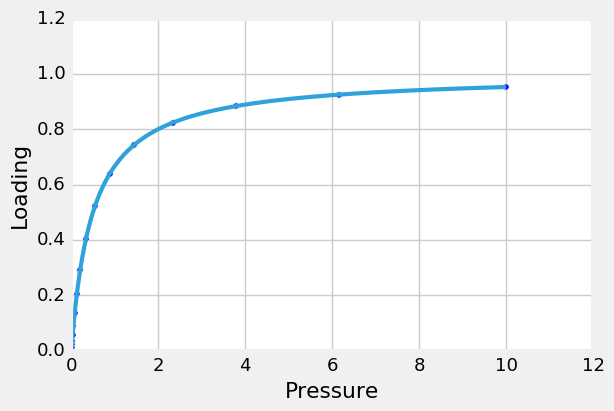

Langmuir identified model parameters:
	K = 10.000058
	M = 0.999999
RMSE =  6.695136876e-07


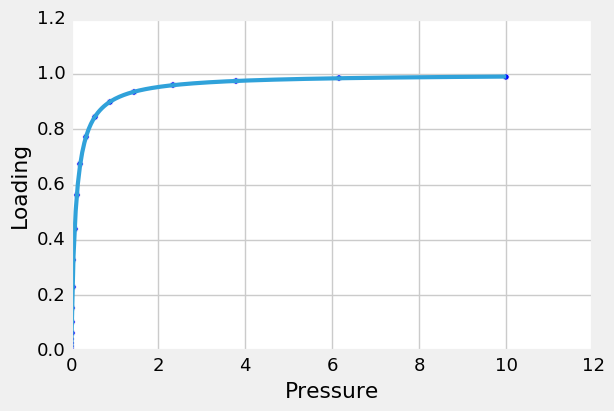

Langmuir identified model parameters:
	K = 19.999965
	M = 1.000000
RMSE =  2.06780693898e-07


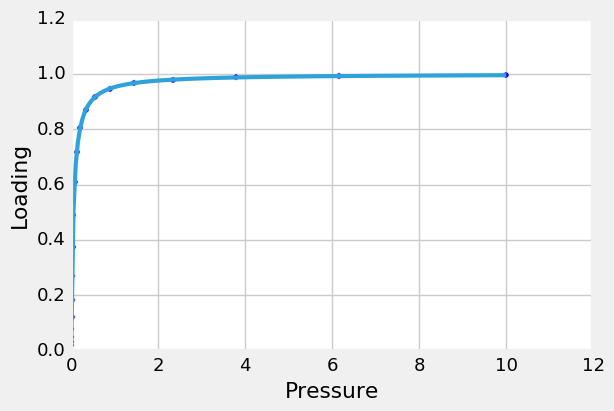

In [4]:
isotherms = [pyiast.ModelIsotherm(dfs[i], pressure_key='P', 
                                  loading_key='L', model='Langmuir') 
             for i in range(3)]

for i in range(len(isotherms)):
    isotherms[i].print_params()
    pyiast.plot_isotherm(isotherms[i])

Plot synthetic data all in one plot for paper

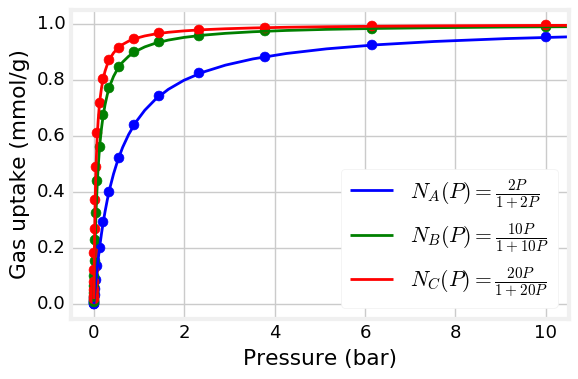

In [5]:
p_plot = np.logspace(-3, np.log10(11))  # for plotting

fig = plt.figure(facecolor='w')
for i in range(len(isotherms)):
    plt.scatter(dfs[i]['P'], dfs[i]['L'], color=colors[i],
               s=50, label=None)
    plt.plot(p_plot, M * langmuirKs[i] * p_plot / (1.0 + langmuirKs[i] * p_plot),
            color=colors[i], linewidth=2, label=r'$N_%s(P) = \frac{%d P}{1+%dP}$' % (
                component_names[i], langmuirKs[i], langmuirKs[i]))

plt.xlim([-.05 * 10, 1.05 * 10])
plt.ylim([-.05 * M, M * 1.05])

plt.xlabel('Pressure (bar)')
plt.ylabel('Gas uptake (mmol/g)')

plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('pure_component_Langmuir.pdf', format='pdf',
            facecolor=fig.get_facecolor())
plt.show()

## Compare pyIAST predicted component loadings to that of competitive Langmuir

Let us consider a tertiary mixture of components 0, 1, and 2 above at a total pressure of `total_pressure` bar.

In [6]:
total_pressure = 1.0

We will explore gas phase composition space ($\{y_i\}$) by generating random compositions and checking that they are within the triangle. We do not want to get too close to a pure phase boundary becuase of numerical instability, so we keep a distance `dx` away from pure phases. We will perform `num_tests` tests.

In [7]:
dx = 0.0001
num_tests = 100

Generate the compositions and store in list `compositions`

In [8]:
compositions = []
test_no = 0
while test_no < num_tests:
    # generate random compoisitions
    y1 = np.random.uniform(dx, 1.0 - dx)
    y2 = np.random.uniform(dx, 1.0 - dx)
    y3 = 1.0 - y2 - y1
    # check that composition is within the triangle
    if y3 < dx:
        continue
    # viable composition
    compositions.append([y1, y2, y3])
    # keep generating until we have num_tests
    test_no += 1

Next, we assert that pyIAST gives the same result as the competitive Langmuir isotherm for each of these compositions.

Function to compute loading according to competitive Langmuir

In [9]:
def competitive_langmuir_loading(partial_pressures, i):
    """
    Calculate loading of component i according to competitive Langmuir
    """
    return M * langmuirKs[i] * partial_pressures[i] / (
        1.0 + np.dot(langmuirKs, partial_pressures))

Function to compute loading according to pyIAST

In [10]:
def iast_loading(partial_pressures, i):
    """
    Calculate loading of component i according to IAST
    
    partial_pressures: Array, partial pressures of each component
    i: component in the mixture
    """
    component_loadings = pyiast.iast(partial_pressures, isotherms)
    return component_loadings[i]

Loop over compositions, assert pyIAST agrees with competitive Langmuir for each component. If this runs, then there is agreement!

In [11]:
for i in range(num_tests):
    partial_pressure = np.array(compositions[i]) * total_pressure
    # for each component...
    for c in range(len(langmuirKs)):
        np.testing.assert_almost_equal(
                competitive_langmuir_loading(partial_pressure, c),
                iast_loading(partial_pressure, c), decimal=4)

### This is using a custom library to plot the phase diagrams for the paper.

Use ternary to plot phase diagram
https://github.com/marcharper/python-ternary

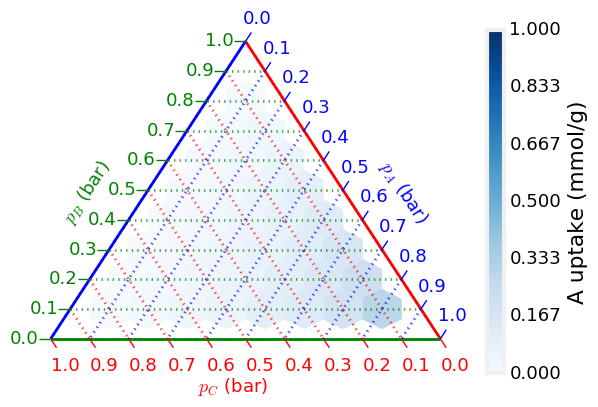

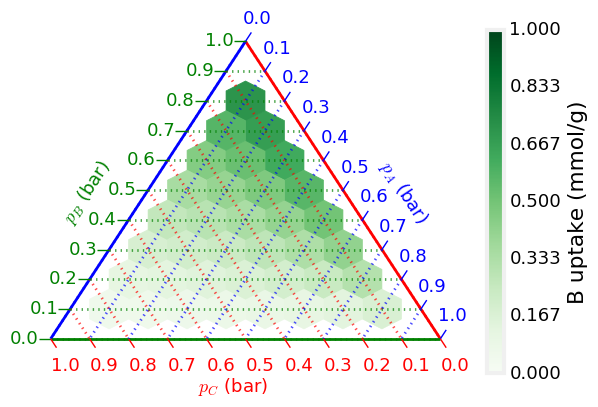

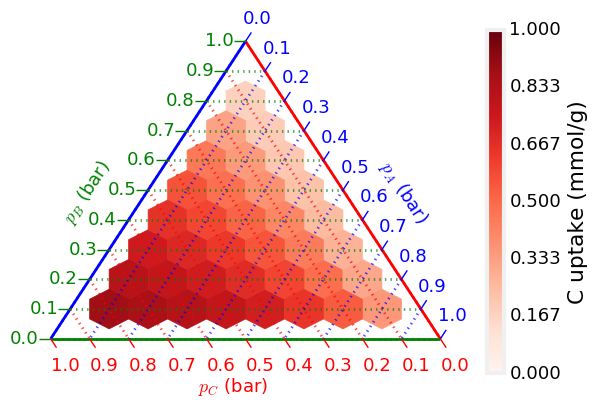

In [14]:
import ternary
scale = 10  # resolution in triangle
axis_colors = {'l':colors[1], 'r':colors[0], 'b':colors[2]}
cmaps = ["Blues", "Greens", "Reds"]
iast_or_lang = 'iast'  # plot results for IAST or for Langmuir isotherm?

for c in range(3):
    if iast_or_lang == 'lang':
        f = lambda p: competitive_langmuir_loading(p, c)
    else:
        f = lambda p: iast_loading(p, c)
    
    # loop over component
    fig, ax = plt.subplots(facecolor='w')
    ax.axis("off")
    figure, tax = ternary.figure(ax=ax, scale=scale)

    tax.heatmapf(f, boundary=False, 
                 style="hexagonal", cmap=plt.cm.get_cmap(cmaps[c]), 
                 vmax=M, vmin=0.0, 
                 cbarlabel="%s uptake (mmol/g)" % component_names[c])

    tax.boundary(linewidth=2.0, axes_colors=axis_colors)

    tax.left_axis_label("$p_B$ (bar)", color=axis_colors['l'], offset=0.16)
    tax.right_axis_label("$p_A$ (bar)", color=axis_colors['r'], offset=0.16)
    tax.bottom_axis_label("$p_C$ (bar)", color=axis_colors['b'], offset=-0.06)

    tax.gridlines(color="blue", multiple=1, linewidth=2,
                 horizontal_kwargs={'color':axis_colors['b']},
                 left_kwargs={'color':axis_colors['l']},
                 right_kwargs={'color':axis_colors['r']},
                 alpha=0.7) # Every 5th gridline, can be a float

    tax.ticks(axis='rlb', linewidth=1, locations=np.arange(scale+1), clockwise=True,
              axes_colors=axis_colors,
              ticks=["%.1f" % (1.0 * i / scale) for i in range(scale+1)], offset=0.03)
    tax.clear_matplotlib_ticks()

    tax._redraw_labels()
   # if iast_or_lang == 'iast':
   #     tax.set_title("IAST uptake, component %d" % c, y=1.08, fontsize=14)
   # if iast_or_lang == 'lang':
   #     tax.set_title("Competitive Langmuir uptake, component %d" % c, y=1.08, fontsize=14)
    plt.tight_layout()
    if iast_or_lang == 'iast':
        plt.savefig("Tertiary_diagram_IAST_component_%d.pdf" % c, format='pdf',
                facecolor=fig.get_facecolor())
    if iast_or_lang == 'lang':
        plt.savefig("Tertiary_diagram_Langmuir_component_%d.pdf" % c, format='pdf',
                facecolor=fig.get_facecolor())
    tax.show()